# Optimization of a power system
Student: Bruno Kiyoshi Ynumaru; Prof. Eduardo Camponogara

In this exercise, you will have the opportunity to approximate a nonlinear problem
as a MILP by means of piecewise-linear models. The power system has 3 buses
as depicted in Fig. 1. Buses 1 and 3 have generation units, whereas bus 2 is a
power consumer. This Figures also gives the maximum power generation ($\bar{P_{gi}}$) and
the power consumption ($\bar{P_{di}}$) of each bus i, under low and high demand. The
properties of the transmission lines appear in Table 1, in pu using a 100 MVA basis,
are indicated in the Figure. The parameters are the resistance $r_{i,j}$ , the reactance $x_{i,j}$
and the number of lines installed between buses i and j.


<img src="Figure1.jpg" alt="Drawing" style="width: 400px; margin-left:auto; margin-right:auto"/>

|Line| $r_{i,j}$ (pu)| $x_{i,j}$ (pu)| ni,j|
|----|---------------|---------------|----------|
|1-2 | 0.030         |0.23           |2         |
|1-3 |0.035          | 0.25          |1         |
|2-3 | 0.025         | 0.20          |1         |

A simplified model is adopted for the transmission network, in which:  
•Lines and transformers are represented by their series impedances in per unit:  
\begin{equation}
z_{i,j} = r_{i,j} + jx_{i,j} \space \space (1)
\end{equation}
where ri;j is the resistance and xi;j is the reactance of line (i; j).  
• Voltage magnitudes are fixed at 1:0 pu.  
• Reactive power balance is supposed to be satisfied.  
With these assumptions, active power flows are expressed as  
\begin{equation}
p.flow \space i \rightarrow j : P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}) \space (2a)\\
p.flow \space j \rightarrow i : P_{j,i} = g_{i,j}-(g_{i,j} cos\theta_{i,j} - b_{i,j} sin \theta_{i,j}) \space (2b) 
\end{equation}  
where $gij$ and $b_{ij}$ are, respectively, the series conductance and series susceptance of
line (i, j), $\theta_{i,j} = (\theta_i - \theta_j)$ and $\theta_i$ is the voltage angle of bus i.  
Conductance and susceptance are calculated as follows  
\begin{equation}
g_{i,j}=\frac{r_{i,j}}{(r^2_{i,j}+x^2_{i,j})}\\
b_{i,j}=-\frac{x_{i,j}}{(r^2_{i,j}+x^2_{i,j})}
\end{equation}  
The power injected into bus i is defined as  
\begin{equation}
P_i=\sum_{j \in N_i} n_{i,j}P_{i,j} = \sum_{j \in N_i}n_{i,j}[g_{i,j}-(g_{i,j}cos\theta_{i,j}+b_{i,j}sin\theta_{i,j}])] \space (3)
\end{equation}  
where $N_i$ is the set of neighboring buses of bus i. To ensure energy conservation, the
following equations must also be satisfied  
\begin{equation}
Pg_i=\bar{Pd_i}+P_i \space (4)
\end{equation}  
Aiming to minimize the power loss in transmission, the power-flow optimization problem could be solved:  

\begin{align}
min &\sum_{i \in N} |P_i| \\
s.t:& Pg_i=\bar{Pd_i}+P_i, \\
&P_i=\sum_{j \in N_i} n_{i,j}P_{i,j}, \\
&0 \le Pg_i \le \bar{Pg_i}, \\
&\theta_i \in [\frac{-\pi}{2},\frac{\pi}{2}, i \in N],  \\
&P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}),\\
&\theta_{i,j}=\theta_i-\theta_j, \\
&\theta_{i,j} \in [-\pi,\pi], i \in N, j \in N_i
\end{align}

Tasks:  
• Reformulate the power-flow optimization problem in MILP using the following piecewise-linear models: CC and SOS2.  
• Implement the models in AMPL, choosing a suitable number of breakpoints to induce a good approximation of the power-flow equations. You may plot the piecewise linear approximations for sin $\theta_{i,j}$ and cos $\theta_{i,j}$ in order to show the degree of approximation.  
• Solve the problem for the low and high power demand cases. Present and illustrate the solutions.  

## Optimization problem solution using Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB, Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import combinations
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

Extract points from non-linear functions:

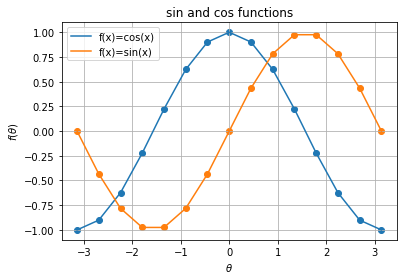

In [2]:
n_points = 15
theta_array = np.linspace(-math.pi,math.pi, n_points)
cos_array = np.cos(theta_array)
sin_array = np.sin(theta_array)
plt.figure()
plt.scatter(theta_array,cos_array)
plt.scatter(theta_array,sin_array)
plt.plot(theta_array,cos_array,label="f(x)=cos(x)")
plt.plot(theta_array,sin_array,label="f(x)=sin(x)")
plt.title("sin and cos functions")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f(\theta)$')
plt.legend()
plt.grid(which="both")
plt.show()

In [3]:
n_busses = 3
bus_set = [i for i in range(1,n_busses + 1)]
print(bus_set)

[1, 2, 3]


In [4]:
Pd_dict_high = {bus_set[0]:1.0,bus_set[1]:3.5,bus_set[2]:5.0}
Pd_dict_low = {bus_set[0]:1.0,bus_set[1]:2.0,bus_set[2]:3.0}

Pgmax_dict = {bus_set[0]:7.0,bus_set[1]:0.0,bus_set[2]:4.0}

In [5]:
b_combs = combinations(bus_set,2) # from now on 'b' stands for bus/busses
b_combs = list(b_combs)
print(b_combs)

[(1, 2), (1, 3), (2, 3)]


In [6]:
r_dict = {b_combs[0]:0.30, b_combs[1]:0.35, b_combs[2]:0.35}
x_dict = {b_combs[0]:0.23, b_combs[1]:0.25, b_combs[2]:0.20}
n_dict = {b_combs[0]:2, b_combs[1]:1, b_combs[2]:1}
print(f'r_dict={r_dict}')
print(f'x_dict={x_dict}')
print(f'n_dict={n_dict}')
z = lambda r,x : r + x*1j
z_dict = {bc:z(r_dict[bc], x_dict[bc]) for bc in b_combs}
print(f'z_dict={z_dict}')

r_dict={(1, 2): 0.3, (1, 3): 0.35, (2, 3): 0.35}
x_dict={(1, 2): 0.23, (1, 3): 0.25, (2, 3): 0.2}
n_dict={(1, 2): 2, (1, 3): 1, (2, 3): 1}
z_dict={(1, 2): (0.3+0.23j), (1, 3): (0.35+0.25j), (2, 3): (0.35+0.2j)}


In [7]:
g = lambda r,x: r / (r**2+x**2)
b = lambda r,x: x / (r**2+x**2)

g_dict = {bc:g(r_dict[bc], x_dict[bc]) for bc in b_combs}
b_dict = {bc:b(r_dict[bc], x_dict[bc]) for bc in b_combs}
print(f'g_dict={g_dict}')
print(f'b_dict={b_dict}')

g_dict={(1, 2): 2.099370188943317, (1, 3): 1.8918918918918919, (2, 3): 2.153846153846154}
b_dict={(1, 2): 1.609517144856543, (1, 3): 1.3513513513513513, (2, 3): 1.230769230769231}


In [8]:
# power flow (P) has different values for forwards (f) and backwards (b) directions
Pf = lambda g,b,theta: g - (g*np.cos(theta) + b*np.sin(theta))
Pb = lambda g,b,theta: g - (g*np.cos(theta) - b*np.sin(theta))

Pf_dict = {bc:Pf(r_dict[bc], x_dict[bc], theta_array) for bc in b_combs}
print(f'Pf_dict={Pf_dict}')
Pb_dict = {bc:Pb(r_dict[bc], x_dict[bc], theta_array) for bc in b_combs}
print(f'Pb_dict={Pb_dict}')

Pf_dict={(1, 2): array([ 0.6       ,  0.67008392,  0.66686818,  0.5909897 ,  0.45747714,
        0.2927743 ,  0.1295026 ,  0.        , -0.07008392, -0.06686818,
        0.0090103 ,  0.14252286,  0.3072257 ,  0.4704974 ,  0.6       ]), (1, 3): array([ 0.7       ,  0.77381004,  0.7636793 ,  0.6716143 ,  0.51584965,
        0.32723644,  0.14313183,  0.        , -0.07381004, -0.0636793 ,
        0.0283857 ,  0.18415035,  0.37276356,  0.55686817,  0.7       ]), (2, 3): array([ 0.7       ,  0.75211585,  0.72458773,  0.62286791,  0.46710326,
        0.28814487,  0.12143764,  0.        , -0.05211585, -0.02458773,
        0.07713209,  0.23289674,  0.41185513,  0.57856236,  0.7       ])}
Pb_dict={(1, 2): array([ 0.6       ,  0.4704974 ,  0.3072257 ,  0.14252286,  0.0090103 ,
       -0.06686818, -0.07008392,  0.        ,  0.1295026 ,  0.2927743 ,
        0.45747714,  0.5909897 ,  0.66686818,  0.67008392,  0.6       ]), (1, 3): array([ 0.7       ,  0.55686817,  0.37276356,  0.18415035,  0.0283857 

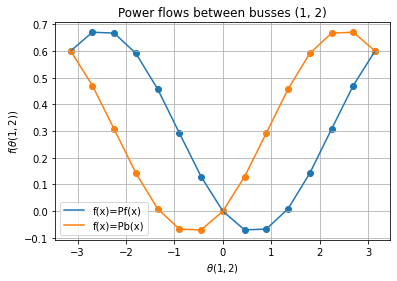

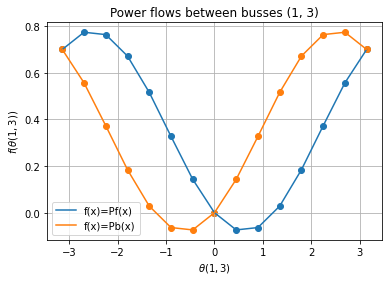

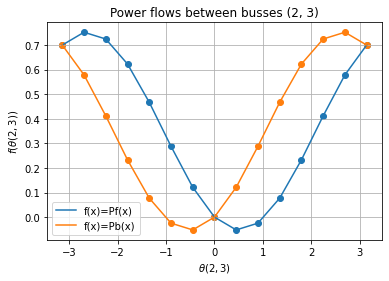

In [9]:
for k, bc in enumerate(b_combs):
    
    plt.figure()
    plt.scatter(theta_array,Pf_dict[bc])
    plt.scatter(theta_array,Pb_dict[bc])
    plt.plot(theta_array,Pf_dict[bc],label="f(x)=Pf(x)")
    plt.plot(theta_array,Pb_dict[bc],label="f(x)=Pb(x)")
    plt.title(f"Power flows between busses {bc}")
    plt.xlabel(fr'$\theta{bc}$')
    plt.ylabel(fr'$f(\theta{bc})$')
    plt.legend()
    plt.grid(which="both")
    plt.show()

## Piecewise linear reformulations



#### Convex-combination - CC

In convex combination approximations, the dependent variable is given by a linear combination of two consecutive points from the available data:
For a given pair of buses $(i,j)$, the CC piecewise linear reformulation is:
\begin{equation} 
(i,j) \in \{1 ,\dots, N\}^2, i \neq j \\
Givens^{(i,j)}: \{(\theta^{(i,j)}_0, P^{(i,j)}_0),\dots, (\theta^{(i,j)}_{(M-1)}, P^{(i,j)}_{(M-1)})\} \\
\theta^{(i,j)} = \sum_{k=0}^{M - 1} \lambda_k^{(i,j)}\theta_{k}^{(i,j)} \\
P^{(i,j)} = \sum_{k=0}^{M - 1} \lambda_k^{(i,j)}P_{k}^{(i,j)} \\
\lambda_k^{(i,j)} \ge 1, k = 0,...,{(M - 1)} \\
1 = \sum^{M - 1}_{k=0} \lambda_k^{(i,j)} \\
1 = \sum^{M - 1}_{k=1}z_k^{(i,j)} \\
z^{(i,j)}_k \in \{0,1\}, k=1,...,{(M-1)} \\
\lambda_0^n \le z_1^{(i,j)} \\
\lambda_{(M-1)}^{(i,j)} \le z_{(M-1)}^{(i,j)} \\
\lambda_k^{(i,j)} \le z_k^{(i,j)} + z_{k+1}, k=1,...,{(M-1)} \\
z_k^{(i,j)} = 1\; \text{if} \;P^{(i,j)} \in [ P_{k-1}^{(i,j)}, P_{k}^{(i,j)} ]
\end{equation}
Where $M$ is the number of available data points for bus pair $(i,j)$ and $N$ is the number of buses in the system.


#### Special Ordered Set of Variables Type 2 - SOS2

\begin{equation} 
(i,j) \in \{1 ,\dots, N\}^2, i \neq j \\
Givens^{(i,j)}: \{(\theta^{(i,j)}_0, P^{(i,j)}_0),\dots, (\theta^{(i,j)}_{(M-1)}, P^{(i,j)}_{(M-1)})\} \\
\theta^{(i,j)} = \sum_{k=0}^{M - 1} \lambda_k^{(i,j)}\theta_{k}^{(i,j)} \\
P^{(i,j)} = \sum_{k=0}^{M - 1} \lambda_k^{(i,j)}P_{k}^{(i,j)} \\
\lambda_k^{(i,j)} \ge 0, k = 0,...,{(M - 1)} \\
1 = \sum^{M - 1}_{k=0} \lambda_k^{(i,j)} \\
\{\lambda_k^{(i,j)}\}_{k=0}^{(M-1)} \in \text{SOS2}
\end{equation}

Where **SOS2** (Special Ordered Set of type 2) is the set of sets that comply to the following criteria:
<ol>
    <li>At most 2 elements are positive.</li>
    <li>In the case 2 elements in the set are positive, they must be consecutive in the ordered set.</li>
</ol>

##### Modeling the SOS2 constraint in linear terms

\begin{equation} 
\lambda_k^{(i,j)} \in [ 0, +\infty ], k = 0,...,{M-1} \\
z_k^{(i,j)} \in \{0,1\} , k = 0,...,{M-1} \\
\lambda_k^{(i,j)} \le z_k , k = 0,...,{M-1} \\
\sum_{k=0}^{M-1} z_k \le 2 \\
z_k^{(i,j)} + z_l^{(i,j)} \le 1, (k,l) \in \{k+2,...,{M-1}\}^2
\end{equation}

## Modeling and solving the problem using Gurobi:

### Convex Combination in Gurobi

In [10]:
cc = Model()
cc.Params.LogFile = "cc_log.txt"
# each bus i is in a certain theta
thetai_vars = cc.addVars(bus_set, lb=-math.pi/2, ub=math.pi/2, vtype=GRB.CONTINUOUS, name="thetai")
# power generated in each bus i, constrained by values given in problem statement
Pgi_vars = cc.addVars(bus_set, lb=0,ub=Pgmax_dict,vtype=GRB.CONTINUOUS, name="Pgi")

# total power flow into each bus i
Pi_vars = cc.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi")

# auxiliary variables which represents each |Pi|
Pi_abs_vars = cc.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi_abs") 

lambda_vars = gp.tupledict() # 1 value per data interval per pair ((n_points-1) * len(b_combs))
z_vars = gp.tupledict() # 1 value per data point per pair (n_points * len(b_combs))
lag_vars = gp.tupledict() # 1 value per pair (len(b_combs))
Pf_vars = gp.tupledict() # 1 value per pair (len(b_combs))
data_indexes = range(n_points)

for pair in b_combs:
    # create lambdas for current pair
    lambda_vars_ = cc.addVars(data_indexes, lb=0.0, vtype=GRB.CONTINUOUS, name=f"lambdas{pair}")
    cc.addConstr(gp.quicksum(lambda_vars_)==1)
    lambda_vars[pair] = lambda_vars_
    
    # z variables indicate in which piece of the piecewise linear function the decision variable is
    # create z variables for current pair
    z_vars_ = cc.addVars(data_indexes[1:], vtype=GRB.BINARY, name=f"z{pair}") # note that first index is removed
    cc.addConstr(gp.quicksum(z_vars_)==1)
    z_vars[pair] = z_vars_
    
    cc.addConstr(lambda_vars_[0]<=z_vars_[1]) # ensure first lambda =0 if decision variable outside of first piece
    cc.addConstr(lambda_vars_[n_points-1]<=z_vars_[n_points-1]) # ensure last lambda =0 if decision variable outside of last piece
    
    for i in range(1,n_points-1):
        cc.addConstr(lambda_vars_[i]<=z_vars_[i]+z_vars_[i+1]) # ensure lambda=0 if decision variable not in any of the neighboring pieces
    
    # create lag variable for current pair
    lag_var = cc.addVar(vtype=GRB.CONTINUOUS, name=f"lag{pair}")
    cc.addConstr(lag_var==(gp.quicksum([lambda_vars_[i]*theta_array[i] for i in data_indexes])), name=f"lag{pair} calculation")
    lag_vars[pair] = lag_var
    
    # create power flow variable for current pair
    Pf_data = Pf_dict[pair] # power flows calculated before for current pair (Pij)
    Pf_var = cc.addVar(vtype=GRB.CONTINUOUS, name=f"Pf{pair}") # Power flow variable for current pair
    cc.addConstr(Pf_var==(gp.quicksum([lambda_vars_[i]*Pf_data[i] for i in data_indexes])), name=f"Pf{pair} calculation")
    Pf_vars[pair] = Pf_var
    
    # not quite necessary, but create theta for each individual bus
    i = pair[0]
    j = pair[1]
    cc.addConstr(lag_var==thetai_vars[i]-thetai_vars[j], name=f"thetas_i=({pair})")
    
for bus in bus_set:
    # energy conservation constraint
    Pi_value = 0
    for pair in b_combs:
        if bus in pair:
            cc.update()
            Pi_value += n_dict[pair] * Pf_vars[pair]
    print(Pi_value)
    cc.addConstr(Pi_vars[bus]==Pi_value)
    cc.addConstr(Pgi_vars[bus]==Pd_dict_high[bus]+Pi_vars[bus])
    cc.addGenConstrAbs(Pi_abs_vars[bus], Pi_vars[bus], name="ABS")
    
    
cc.setObjective(gp.quicksum(Pi_abs_vars))
cc.update()

cc.display()


Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-20
Set parameter LogFile to value "cc_log.txt"
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(1, 3)>
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(2, 3)>
<gurobi.LinExpr: Pf(1, 3) + Pf(2, 3)>
Minimize
  <gurobi.LinExpr: Pi_abs[1] + Pi_abs[2] + Pi_abs[3]>
Subject To
R0: <gurobi.LinExpr: lambdas(1, 2)[0] + lambdas(1, 2)[1] + lambdas(1, 2)[2] +
lambdas(1, 2)[3] + lambdas(1, 2)[4] + lambdas(1, 2)[5] + lambdas(1, 2)[6] + lambdas(1,
2)[7] + lambdas(1, 2)[8] + lambdas(1, 2)[9] + lambdas(1, 2)[10] + lambdas(1, 2)[11] +
 lambdas(1, 2)[12] + lambdas(1, 2)[13] + lambdas(1, 2)[14]> = 1
R1: <gurobi.LinExpr: z(1, 2)[1] + z(1, 2)[2] + z(1, 2)[3] + z(1, 2)[4] + z(1, 2)[5] +
z(1, 2)[6] + z(1, 2)[7] + z(1, 2)[8] + z(1, 2)[9] + z(1, 2)[10] + z(1, 2)[11] + z(1,
 2)[12] + z(1, 2)[13] + z(1, 2)[14]> = 1
  R2: <gurobi.LinExpr: lambdas(1, 2)[0] + -1.0 z(1, 2)[1]> <= 0
  R3: <gurobi.LinExpr: lambdas(1, 2)[14] + -1.0 z(1, 2)[14]> <= 0
  R4: <gurob

In [11]:
cc.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 66 rows, 105 columns and 330 nonzeros
Model fingerprint: 0x30c766dc
Model has 3 general constraints
Variable types: 63 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


### Special Ordered Set of Variables Type 2 in Gurobi

In [12]:
sos2 = Model()
sos2.Params.LogFile = "sos2_log.txt"
# each bus i is in a certain theta
thetai_vars = sos2.addVars(bus_set, lb=-math.pi/2, ub=math.pi/2, vtype=GRB.CONTINUOUS, name="thetai")
# power generated in each bus i, constrained by values given in problem statement
Pgi_vars = sos2.addVars(bus_set, lb=0,ub=Pgmax_dict,vtype=GRB.CONTINUOUS, name="Pgi")

# total power flow into each bus i
Pi_vars = sos2.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi")

# auxiliary variables which represents each |Pi|
Pi_abs_vars = sos2.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi_abs") 

lambda_vars = gp.tupledict() # 1 value per data interval per pair ((n_points-1) * len(b_combs))
z_vars = gp.tupledict() # 1 value per data point per pair (n_points * len(b_combs))
lag_vars = gp.tupledict() # 1 value per pair (len(b_combs))
Pf_vars = gp.tupledict() # 1 value per pair (len(b_combs))
data_indexes = range(n_points)

for pair in b_combs:
    # create lambdas for current pair
    lambda_vars_ = sos2.addVars(data_indexes, lb=0.0, vtype=GRB.CONTINUOUS, name=f"lambdas{pair}")
    sos2.addConstr(gp.quicksum(lambda_vars_)==1)
    lambda_vars[pair] = lambda_vars_
    
    # z variables indicate in which piece of the piecewise linear function the decision variable is
    # create z variables for current pair
    z_vars_ = sos2.addVars(data_indexes[1:], vtype=GRB.BINARY, name=f"z{pair}") # note that first index is removed
    sos2.addConstr(gp.quicksum(z_vars_)==1)
    z_vars[pair] = z_vars_
    
    sos2.addConstr(lambda_vars_[0]<=z_vars_[1]) # ensure first lambda =0 if decision variable outside of first piece
    sos2.addConstr(lambda_vars_[n_points-1]<=z_vars_[n_points-1]) # ensure last lambda =0 if decision variable outside of last piece
    
    for i in range(1,n_points-1):
        sos2.addConstr(lambda_vars_[i]<=z_vars_[i]+z_vars_[i+1]) # ensure lambda=0 if decision variable not in any of the neighboring pieces
    
    # create lag variable for current pair
    lag_var = sos2.addVar(vtype=GRB.CONTINUOUS, name=f"lag{pair}")
    sos2.addConstr(lag_var==(gp.quicksum([lambda_vars_[i]*theta_array[i] for i in data_indexes])), name=f"lag{pair} calculation")
    lag_vars[pair] = lag_var
    
    # create power flow variable for current pair
    Pf_data = Pf_dict[pair] # power flows calculated before for current pair (Pij)
    Pf_var = sos2.addVar(vtype=GRB.CONTINUOUS, name=f"Pf{pair}") # Power flow variable for current pair
    sos2.addConstr(Pf_var==(gp.quicksum([lambda_vars_[i]*Pf_data[i] for i in data_indexes])), name=f"Pf{pair} calculation")
    Pf_vars[pair] = Pf_var
    
    # not quite necessary, but create theta for each individual bus
    i = pair[0]
    j = pair[1]
    sos2.addConstr(lag_var==thetai_vars[i]-thetai_vars[j], name=f"thetas_i=({pair})")
    
for bus in bus_set:
    # energy conservation constraint
    Pi_value = 0
    for pair in b_combs:
        if bus in pair:
            sos2.update()
            Pi_value += n_dict[pair] * Pf_vars[pair]
    print(Pi_value)
    sos2.addConstr(Pi_vars[bus]==Pi_value)
    sos2.addConstr(Pgi_vars[bus]==Pd_dict_high[bus]+Pi_vars[bus])
    sos2.addGenConstrAbs(Pi_abs_vars[bus], Pi_vars[bus], name="ABS")
    
    
sos2.setObjective(gp.quicksum(Pi_abs_vars))
sos2.update()

sos2.display()


Set parameter LogFile to value "sos2_log.txt"
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(1, 3)>
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(2, 3)>
<gurobi.LinExpr: Pf(1, 3) + Pf(2, 3)>
Minimize
  <gurobi.LinExpr: Pi_abs[1] + Pi_abs[2] + Pi_abs[3]>
Subject To
R0: <gurobi.LinExpr: lambdas(1, 2)[0] + lambdas(1, 2)[1] + lambdas(1, 2)[2] +
lambdas(1, 2)[3] + lambdas(1, 2)[4] + lambdas(1, 2)[5] + lambdas(1, 2)[6] + lambdas(1,
2)[7] + lambdas(1, 2)[8] + lambdas(1, 2)[9] + lambdas(1, 2)[10] + lambdas(1, 2)[11] +
 lambdas(1, 2)[12] + lambdas(1, 2)[13] + lambdas(1, 2)[14]> = 1
R1: <gurobi.LinExpr: z(1, 2)[1] + z(1, 2)[2] + z(1, 2)[3] + z(1, 2)[4] + z(1, 2)[5] +
z(1, 2)[6] + z(1, 2)[7] + z(1, 2)[8] + z(1, 2)[9] + z(1, 2)[10] + z(1, 2)[11] + z(1,
 2)[12] + z(1, 2)[13] + z(1, 2)[14]> = 1
  R2: <gurobi.LinExpr: lambdas(1, 2)[0] + -1.0 z(1, 2)[1]> <= 0
  R3: <gurobi.LinExpr: lambdas(1, 2)[14] + -1.0 z(1, 2)[14]> <= 0
  R4: <gurobi.LinExpr: lambdas(1, 2)[1] + -1.0 z(1, 2)[1] + -1.0 z(1, 2)[2]> <= 0
  R5: <gurobi.LinEx

In [13]:
sos2.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 66 rows, 105 columns and 330 nonzeros
Model fingerprint: 0x30c766dc
Model has 3 general constraints
Variable types: 63 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


### Using Gurobi built-in PWL constraints

In [15]:
m = Model()
m.Params.LogFile = "m_log.txt"
# each bus i is in a certain theta
thetai_vars = m.addVars(bus_set, lb=-math.pi/2, ub=math.pi/2, vtype=GRB.CONTINUOUS, name="thetai")
# power generated in each bus i, constrained by values given in problem statement
Pgi_vars = m.addVars(bus_set, lb=0,ub=Pgmax_dict,vtype=GRB.CONTINUOUS, name="Pgi")

# total power flow into each bus i
Pi_vars = m.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi")

# auxiliary variables which represents each |Pi|
Pi_abs_vars = m.addVars(bus_set, vtype=GRB.CONTINUOUS, name="Pi_abs") 

lag_vars = gp.tupledict() # 1 value per pair (len(b_combs))
Pf_vars = gp.tupledict() # 1 value per pair (len(b_combs))
data_indexes = range(n_points)
pwlf = {}
for pair in b_combs:

    # create lag variable for current pair
    lag_var = m.addVar(vtype=GRB.CONTINUOUS, name=f"lag{pair}")
    lag_vars[pair] = lag_var
    
    # create power flow variable for current pair
    Pf_data = Pf_dict[pair] # power flows calculated before for current pair (Pij)
    Pf_var = m.addVar(vtype=GRB.CONTINUOUS, name=f"Pf{pair}") # Power flow variable for current pair
    Pf_vars[pair] = Pf_var
    
    pwlf[pair] = m.addGenConstrPWL(lag_var, Pf_var, theta_array, Pf_data, f"P(theta) pair {pair}")
    
    # not quite necessary, but create theta for each individual bus
    i = pair[0]
    j = pair[1]
    m.addConstr(lag_var==thetai_vars[i]-thetai_vars[j], name=f"thetas_i=({pair})")
    
for bus in bus_set:
    # energy conservation constraint
    Pi_value = 0
    for pair in b_combs:
        if bus in pair:
            m.update()
            Pi_value += n_dict[pair] * Pf_vars[pair]
    print(Pi_value)
    m.addConstr(Pi_vars[bus]==Pi_value)
    m.addConstr(Pgi_vars[bus]==Pd_dict_high[bus]+Pi_vars[bus])
    m.addGenConstrAbs(Pi_abs_vars[bus], Pi_vars[bus], name="ABS")
    
    
m.setObjective(gp.quicksum(Pi_abs_vars))
m.update()

m.display()


Set parameter LogFile to value "m_log.txt"
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(1, 3)>
<gurobi.LinExpr: 2.0 Pf(1, 2) + Pf(2, 3)>
<gurobi.LinExpr: Pf(1, 3) + Pf(2, 3)>
Minimize
  <gurobi.LinExpr: Pi_abs[1] + Pi_abs[2] + Pi_abs[3]>
Subject To
  thetas_i=((1, 2)): <gurobi.LinExpr: -1.0 thetai[1] + thetai[2] + lag(1, 2)> = 0
  thetas_i=((1, 3)): <gurobi.LinExpr: -1.0 thetai[1] + thetai[3] + lag(1, 3)> = 0
  thetas_i=((2, 3)): <gurobi.LinExpr: -1.0 thetai[2] + thetai[3] + lag(2, 3)> = 0
  R3: <gurobi.LinExpr: Pi[1] + -2.0 Pf(1, 2) + -1.0 Pf(1, 3)> = 0
  R4: <gurobi.LinExpr: Pgi[1] + -1.0 Pi[1]> = 1
  R5: <gurobi.LinExpr: Pi[2] + -2.0 Pf(1, 2) + -1.0 Pf(2, 3)> = 0
  R6: <gurobi.LinExpr: Pgi[2] + -1.0 Pi[2]> = 3.5
  R7: <gurobi.LinExpr: Pi[3] + -1.0 Pf(1, 3) + -1.0 Pf(2, 3)> = 0
  R8: <gurobi.LinExpr: Pgi[3] + -1.0 Pi[3]> = 5
Bounds
  -1.5708 <= thetai[1] <= 1.5708
  -1.5708 <= thetai[2] <= 1.5708
  -1.5708 <= thetai[3] <= 1.5708
  0 <= Pgi[1] <= 7
  Pgi[2] = 0
  0 <= Pgi[3] <= 4
